# Scalecast 🌄 with eCommerce dataset

This notebook details a time series analysis and forecasting application performed with scalecast. The notebook starts with an exploratory data analysis; moves to time series decomposition; forecasts manually with an ARIMA model; forecasts manually with a multiple linear regression model; moves to automated forecasting with scikit-learn models, Facebook Prophet, and LinkedIn Greykite/Silverkite; and finally finishes with combination modeling.

The utilized dataset is available on kaggle: https://www.kaggle.com/carrie1/ecommerce-data/

## Library Imports
First, let's import the libraries and read the data. Some data preprocessing in pandas will be necessary before calling scalecast.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.Forecaster import _estimators_

plot_dim = (15,7)
sns.set(rc={'figure.figsize':plot_dim})

It is important to let pandas know that the date column should be datetime type. That's why we pass the argument `parse_dates=['InvoiceDate']`.

In [2]:
data = pd.read_csv('eCommerce.csv',parse_dates=['InvoiceDate'])

## Exploratory Data Analysis

Let's view the data's first five rows.

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Now, let's view the data's dimensions.

In [4]:
data.shape

(541909, 8)

Let's see how much time these 550,000 observations span.

In [5]:
print('first date in data:',data['InvoiceDate'].min())
print('last date in data:',data['InvoiceDate'].max())

first date in data: 2010-12-01 08:26:00
last date in data: 2011-12-09 12:50:00


In spite of there being over half a million rows, there is only about a year's worth of data to analyze. Before proceding, we should decide a datetime frequency to aggregate the data to, otherwise we will be trying to forecast with an incosistent interval of time between observations. This decision depends on what question we are trying to answer. For this example, let's try answering the question of if we can accurately predict business-daily gross sales revenues over four business weeks. This means we will be removing sales that were negative in value (probably representing returns), creating a "Sales" column by multiplying quantity by price, and aggregating the entire dataframe to the daily level. Then, we drop dates that are not considered a "business day" and fill any days that show no sales with 0.

In [6]:
# drop negative sales quantities
data = data.loc[data['Quantity'] > 0]
# create the Sales column
data['Sales'] = data['Quantity']*data['UnitPrice']
# aggregate the dataframe to the daily level
dt_aggr = 'D'
data['DateTime'] = data['InvoiceDate'].dt.floor(dt_aggr)
tbl = data.groupby('DateTime')['Sales'].sum().reset_index()
# view first 5 rows
tbl.head()

,DateTime,Sales
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-05,31774.95
4,2010-12-06,54830.46


In [7]:
tbl.shape

(305, 2)

In [8]:
print('first date in data:',tbl['DateTime'].min())
print('last date in data:',tbl['DateTime'].max())

first date in data: 2010-12-01 00:00:00
last date in data: 2011-12-09 00:00:00


It is possible that after making this aggregation to the business-daily level, some date observations in the range are missing. Some forecasting libraries will process missing data for you automatically, but because scalecast mixes so many model concepts, it is necessary to have every possible date in a given range represented. If we run the code below, we will limit the dataframe to only business days and any missing dates will have their sales filled with 0.

In [9]:
all_dates = pd.DataFrame({'DateTime':pd.bdate_range(start=tbl['DateTime'].min(),end=tbl['DateTime'].max())})
full_data = all_dates.merge(tbl,on='DateTime',how='left').sort_values(['DateTime']).fillna(0)
full_data.head()

,DateTime,Sales
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-06,54830.46
4,2010-12-07,99618.20


Let's see how that looks plotted.

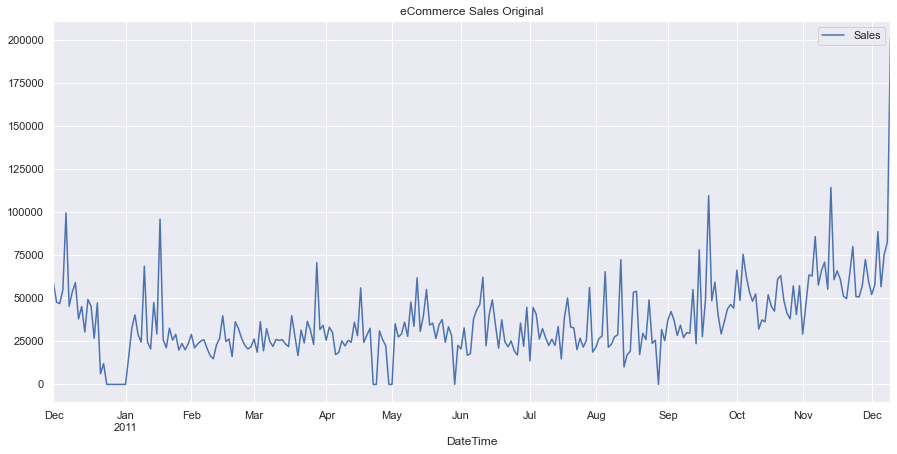

In [10]:
full_data.plot(x='DateTime',y='Sales',title='eCommerce Sales Original')
plt.show()

We notice the last observation in the dataframe is an outlier. Let's look at it more closely.

In [11]:
full_data.sort_values(['Sales'],ascending=False).head(1)

,DateTime,Sales
267,2011-12-09,200920.6


There are many ways to handle outliers in time series, but we will simply be dropping the observation.

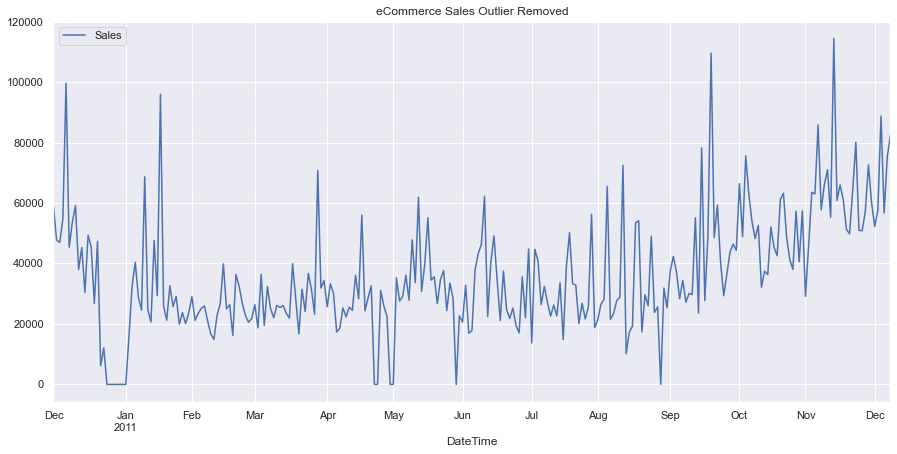

In [12]:
full_data = full_data.loc[0:266]
full_data.plot(x='DateTime',y='Sales',title='eCommerce Sales Outlier Removed')
plt.show()

The last preprocessing function we want to perform is removing the first month or so of observations because so many of them are 0 or close-to-0 in value. Starting January 4, 2011, we see a more normal pattern.

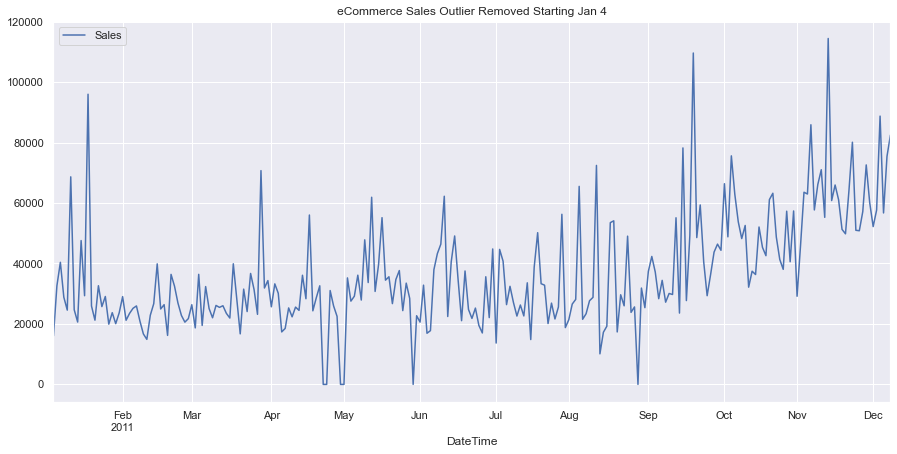

In [13]:
full_data = full_data.loc[full_data['DateTime'] >= datetime.datetime(2011,1,4)]
full_data.plot(x='DateTime',y='Sales',title='eCommerce Sales Outlier Removed Starting Jan 4')
plt.show()

Much better. In the real world, we might want to know more about that outlier -- why it exists, the best way to mitigate it, etc. This example is more interested in producing forecasts and showing the scalecast process, so we are going to sweep the issue of this outlier under the rug and forget about it. Let's now try to get a better idea of how the data is distributed.

In [14]:
full_data.describe()

,Sales
count,243.000000
mean,36472.037049
std,18663.397826
min,0.000000
25%,24215.185000
50%,31515.580000
75%,47698.440000
max,114419.890000


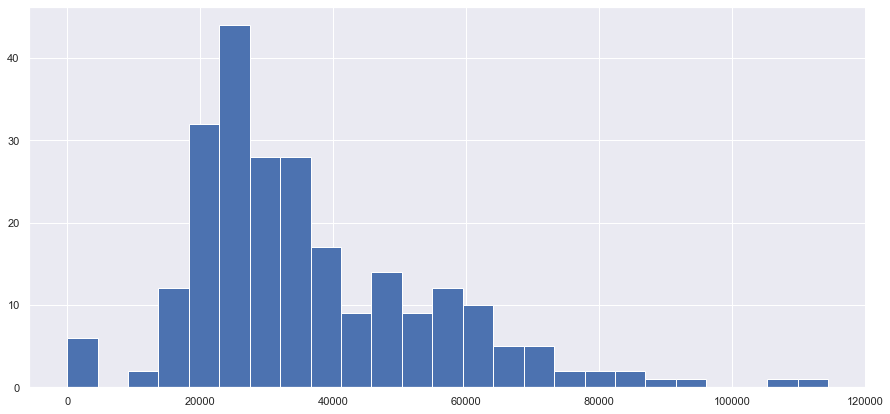

In [15]:
full_data['Sales'].hist(bins=25)
plt.show()

The remaining data looks somewhat normally distributed with a slight right skew.

## Forecast with Scalecast
To load the object, we call the Forecaster() function with the `y` and `current_dates` parameters specified. If we hadn't already dropped the first observations of the data before calling the object, we could have done it by using the `keep_smaller_history()` function as shown below. We can then plot the values that we will be using for forecasting.

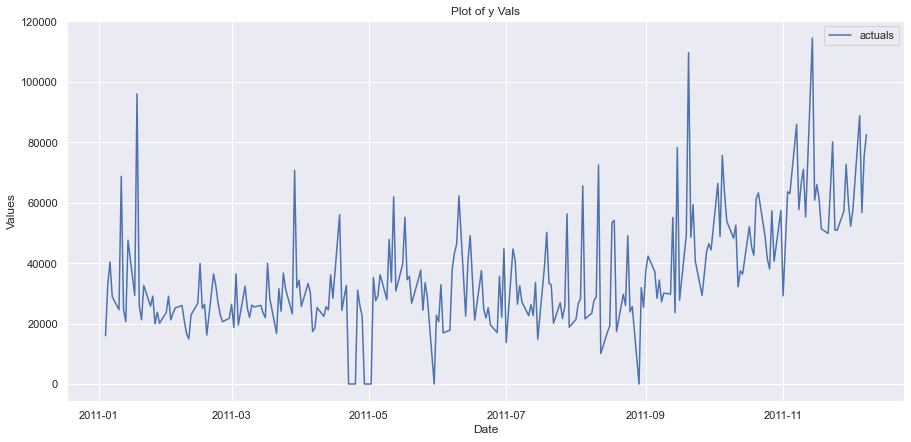

In [16]:
f = Forecaster(y=full_data['Sales'],current_dates=full_data['DateTime'])
f.keep_smaller_history('2011-01-04')
f.plot()

The first thing you should do after initializing the object is set its test length. What that length is is up to you. The longer the length, the more confident you can be about your reported error/accuracy metrics. The library requires a test length of at least 1. Let's set our test length to be the same size as our forecast length: 4 business weeks or 20 business days.

In [17]:
f.set_test_length(20)

Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We leave the test set out of all visualizations (`train_only=True`) to not leak data when making decisions about which signals exist in the data.

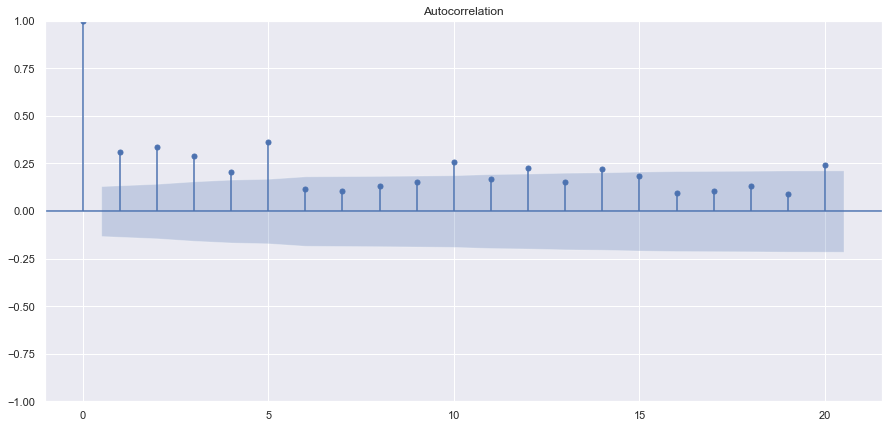

In [18]:
f.plot_acf(train_only=True,lags=20)
plt.show()

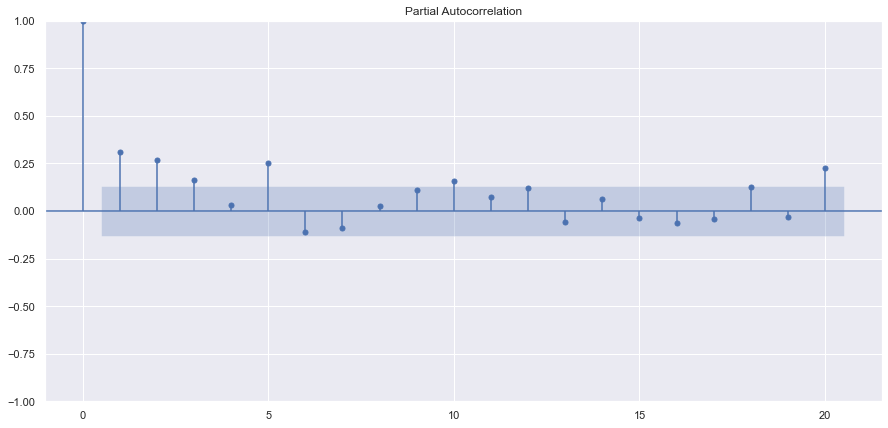

In [19]:
f.plot_pacf(train_only=True,lags=20)
plt.show()

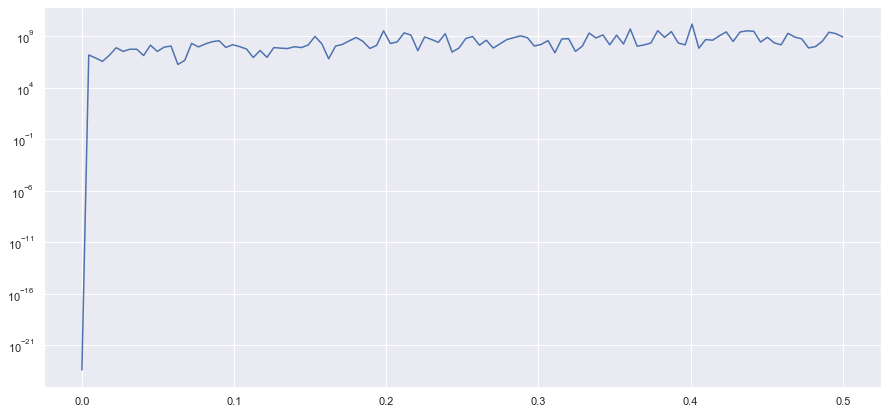

In [20]:
a, b = f.plot_periodogram(diffy=True,train_only=True)
plt.semilogy(a, b)
plt.show()

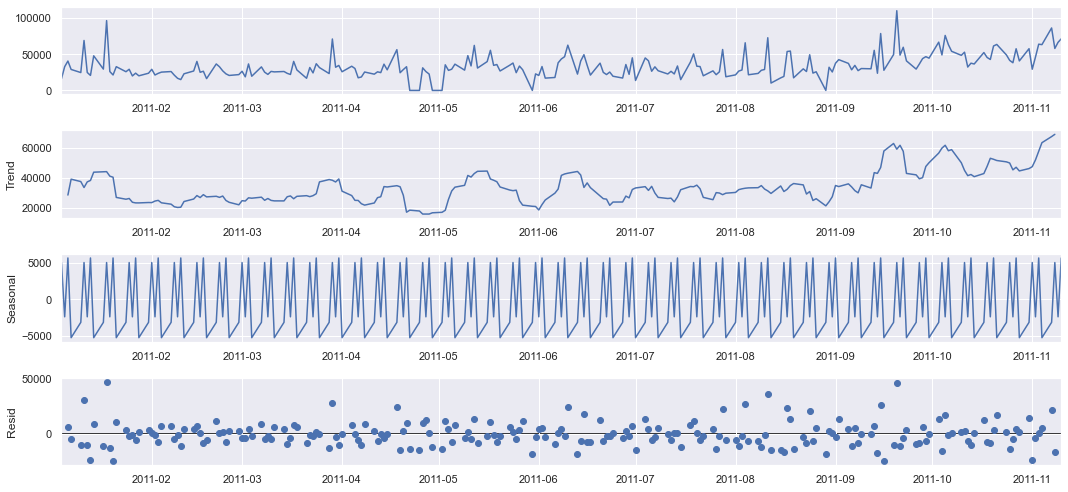

In [21]:
f.seasonal_decompose(train_only=True).plot()
plt.show()

From these graphs, we get a sense that the data has a seasonal pattern over five periods, or equal to one business week. The data appears to be autocorrelated at least back 5 periods, but probably up to 10 or 20. This is good information to use when deciding how to specify the forecasts. 

Now, let's test the data's stationarity using the Augmented Dickey-Fuller test. The null hypothesis of this test is that the data is not stationary. To return the p-val and critical value from this test, pass `full_res=True` as an argument. The way we have the test specified, it will simply print out the implications from the test.

In [22]:
isstationary = f.adf_test(quiet=False)

series might not be stationary


Since our test implies non-stationarity, let's view all these plots again, but pass differenced data into them by using the `diffy=1` argument.

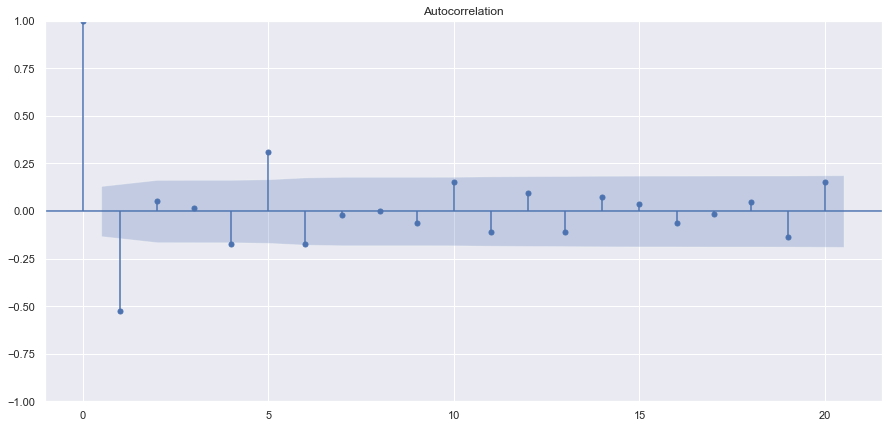

In [23]:
f.plot_acf(diffy=1,train_only=True,lags=20)
plt.show()

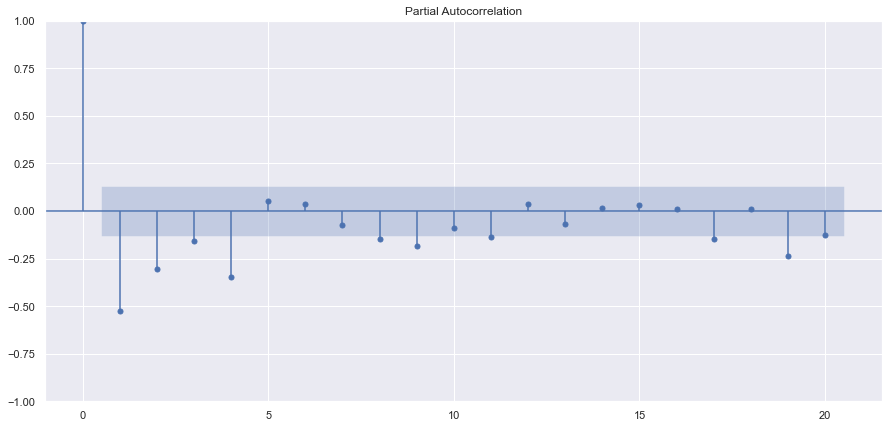

In [24]:
f.plot_pacf(diffy=1,train_only=True,lags=20)
plt.show()

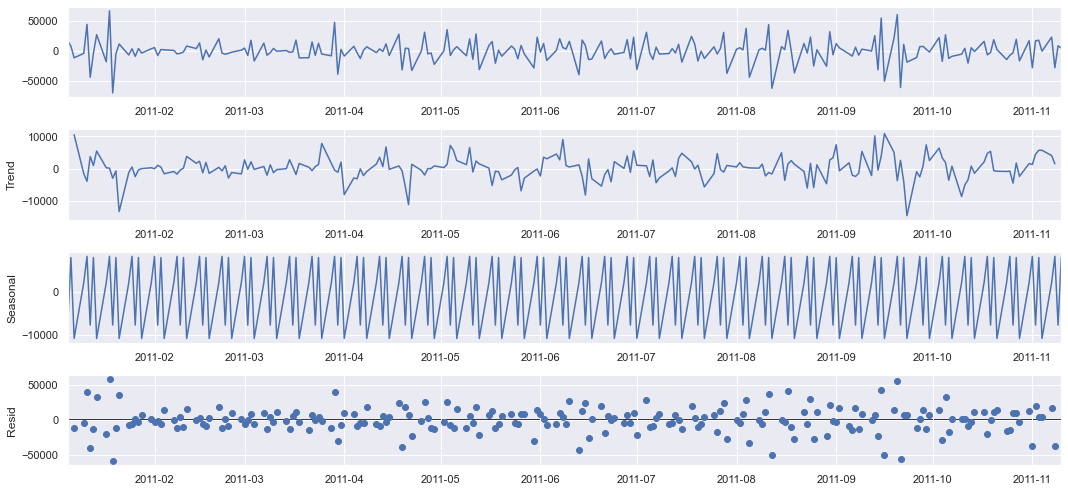

In [25]:
f.seasonal_decompose(diffy=1,train_only=True).plot()
plt.show()

This doesn't give us a very different view of the data, but reinforces that there is strong autocorrelation in our dataset. Some of that can be controlled by using the series' first difference.

### ARIMA
Now, let's run a common time-series model: ARIMA. Using the output from the plots above, as well as the results from the ADF test, we can specify a 4,1,0 x 2,0,0 ordered model. The seasonal period will be one business week--5 periods.

Before running any forecast, we need to generate a forecast period. We are attempting to predict 4 weeks into the future, so we generate 20 future dates. Other ways to generate a forecast interval include:
- `set_last_future_date()`
- `ingest_Xvars_df(use_future_dates=True)`

In [26]:
f.generate_future_dates(20)

To run an ARIMA model, we first set the estimator to ARIMA, then call the `manual_forecast()` function. We can run as many ARIMA models as we like, and differentiate them by using the `call_me` argument. By default, the model will be called whatever the estimator is ("arima" is "arima", "mlr" is "mlr", etc.)

In [27]:
f.set_estimator('arima')
f.manual_forecast(order=(4,1,0),seasonal_order=(2,0,0,5))
f.save_summary_stats()

f.manual_forecast(order=(4,1,1),seasonal_order=(2,0,1,5),call_me='arima_ma_terms')
f.save_summary_stats()

We can view the results of the model by plotting the test-set predictions with the actual test-set observations.

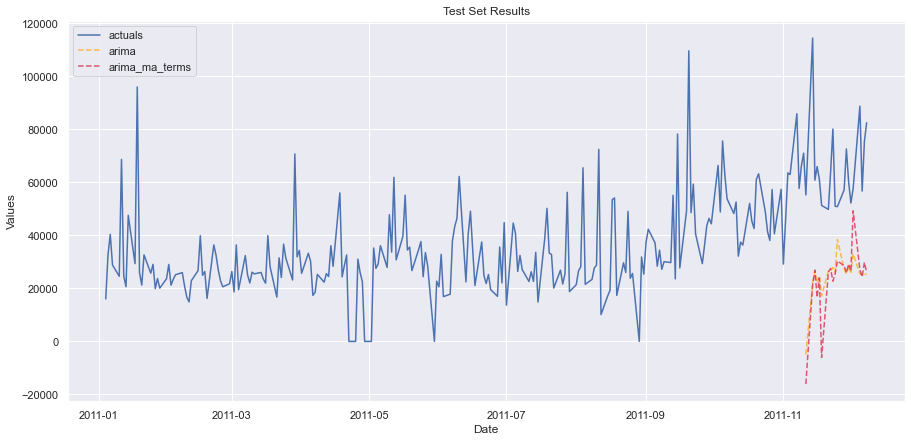

In [28]:
f.plot_test_set()

Those models do not look like they are fitting the test-set data well at all. That is bound to happen sometimes for any given series.

In spite of how poorly these models fit, let's view the forecast by calling the `plot()` function. We can also print out interesting model information using the `print_attr` argument. Let's print out the Test-Set RMSE. We can call this with either 'LevelTestSetRMSE' or 'TestSetRMSE'. These will only be different when the series was differenced before modeling. For this ARIMA model, these will return identical values. For later models in this example where data will be differenced, they will be different values, but to fairly compare metrics across models, we should use level metrics.

arima LevelTestSetRMSE: 44408.22553323487
arima_ma_terms LevelTestSetRMSE: 46402.81835590482


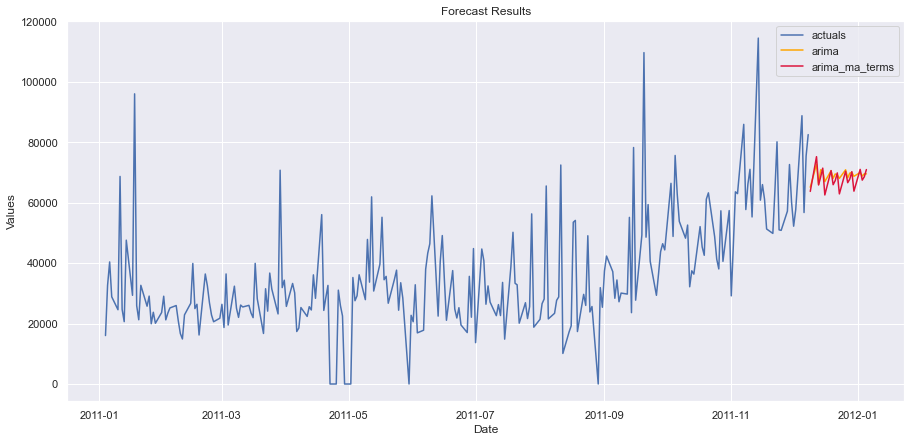

In [29]:
f.plot(print_attr=['LevelTestSetRMSE'])

Although the test-set predictions looked far off, the resulting forecasts do not look that unreasonable.

The RMSE from this model can be considered a baseline to beat with more advanced modeling.

Because the first ARIMA model run returned a better out-of-sample RMSE, we can delete the second one out of memory.

In [30]:
f.pop('arima_ma_terms')

You may have noticed we called a function `save_summary_stats()` after running each ARIMA model. Most models allow feature information to be saved from them using `save_feature_importance()` or `save_summary_stats()`. Some models don't allow either. They should be called before running a new model because they automatically save that information for the last model run only.

We can see the summary statistics for an ARIMA model exporting the saved summary stats to a dataframe.

In [31]:
f.export_summary_stats(model='arima')

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-8.659000e-01,6.800000e-02,-1.273300e+01,0.000,-9.990000e-01,-7.330000e-01
ar.L2,-6.966000e-01,8.600000e-02,-8.088000e+00,0.000,-8.650000e-01,-5.280000e-01
ar.L3,-5.995000e-01,9.000000e-02,-6.698000e+00,0.000,-7.750000e-01,-4.240000e-01
ar.L4,-5.584000e-01,1.010000e-01,-5.527000e+00,0.000,-7.560000e-01,-3.600000e-01
ar.S.L5,-2.816000e-01,1.050000e-01,-2.692000e+00,0.007,-4.870000e-01,-7.700000e-02
ar.S.L10,-1.006000e-01,9.500000e-02,-1.054000e+00,0.292,-2.880000e-01,8.600000e-02
sigma2,2.199000e+08,7.640000e-10,2.880000e+17,0.000,2.200000e+08,2.200000e+08


### Linear Regression
We can use many other models through scalecast. One of the most basic of these is Multiple Linear Regression. Unlike ARIMA, we don't specify orders on this model, but we can add similar regressors, including autoregressive and seasonal terms, as well as a time trend.

First, let's begin with autoregressive terms, which are lags of the dependent variable values. We can add 1-4 lags, as well as the 5th and 10th lags to account for some seasonality, similar to the order we specified in the ARIMA models.

In [32]:
f.add_ar_terms(4) # 1-4 lags

In [33]:
f.add_AR_terms((2,5)) # 5th and 10th lags

To account for stationarity, which is done by setting the middle term to 1 in ARIMA, we have to difference our data before modeling with linear regression.

In [34]:
f.diff()

We can confirm the first-differenced data's (probable) stationarity with another ADF test.

In [35]:
isstationary = f.adf_test(quiet=False)

series appears to be stationary


Let's plot its first difference.

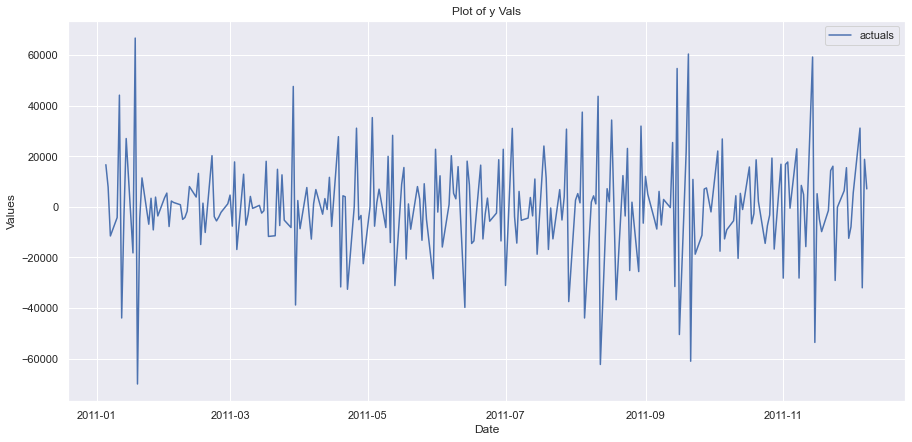

In [36]:
f.plot(models=None)

Let's now add additional seasonality to the model regressors. The main seasonality that we have been able to confirm is weekly, so we can add the 'dayofweek' regressor to our object. We have three options: we can use a sin/cos transformation that accounts for regular fluctuations in the data in a cyclical form; we can add the data as 4-5 dummies using `dummy=True` and specifying the `drop_first` parameter; or we can just use the raw 1-5 numerical output, which is the default (a decision tree model may handle this last kind of regressor better than a linear model). Any decision we make in this regard has its pros and cons. For this example, we will use the sin/cos transformation. This allows relatively few (2) regressors to account for a lot of seasonal variation in the data, but it makes the assumption that the seasonality is cyclical in nature.

Other seasonal regressors are available and can be specified in the same way, including 'day', 'week', 'month', 'year', 'hour', 'minute' and more.

In [37]:
f.add_seasonal_regressors('dayofweek',raw=False,sincos=True)

Let's also add a time trend.

In [38]:
f.add_time_trend()

Other options for adding regressors include:
- `add_combo_regressors()`
- `add_poly_terms()`
- `add_covid19_regressor()`
- `add_other_regressor()`
- `ingest_Xvars_df()`
- `add_exp_terms()`
- `add_logged_terms()`
- `add_pt_terms()`
- `add_diffed_terms()`
- `add_lagged_terms()`

See the [documentation](https://github.com/mikekeith52/scalecast/blob/main/docs/xvars.md)

Let's see the names of the regressors we have added.

In [39]:
f.get_regressor_names()

['AR1',
 'AR2',
 'AR3',
 'AR4',
 'AR5',
 'AR10',
 'dayofweeksin',
 'dayofweekcos',
 't']

When adding these and other kinds of regressors, it is possible to change the names of some of them. This can come in handy to reference later. If any regressors begin with uppercase "AR", the forecasting mechanisms in most of the models will assume such terms are autoregressive in nature and those terms are handled differently. So, be careful when naming variables.

Let's move to modeling with a linear model. Any arguments that the linear model from the scikit-learn library accepts can also be accepted here. In addition, the following arguments are available for all sklearn models:
- `Xvars` (arguments include "all", None, and list-like objects) -- default is always None, but for models that require regressors, this is treated the same as "all"
- `normalizer` (arguments are None, "minmax", "normalize", "pt", and "scale") -- default is always "minmax"
- `call_me` -- does not affect the model's evaluation at all, just names the model for reference later

In [40]:
f.set_estimator('mlr')
f.manual_forecast(normalizer=None,Xvars=None)

Like the ARIMA model, we can see its performance on the test set. Note that all forecasting in this module, even on the test set, is dynamic in nature so that no training-set information is leaked but autoregressive and seasonal patterns can still be predicted. We can trust that this is a true performance on 20 days of out-of-sample data.

The way the forecasting mechanism works (when AR terms are involved) is by making a prediction one step into the future then filling in those predictions to create new AR terms, until the entire forecast interval has been predicted. This is true for testing and forecasting, but validating is non-dynamic by default. Both validating and testing can be either dynamic or non-dynamic; this will be explored later. With large test, validation, or forecast intervals, the forecasting may slow down considerably if everything is kept dynamic. However, if AR terms have *not* been added to the regressors, forecasting times are similar to any non-time-series prediction application.

Since the ARIMA model was run on level data and the MLR was run on differenced data, to compare them, the plots of the test set and forecasts will revert to level automatically, but `level=True` is available as an argument if all models were run on differenced data but you want to see their performance on the level test set.

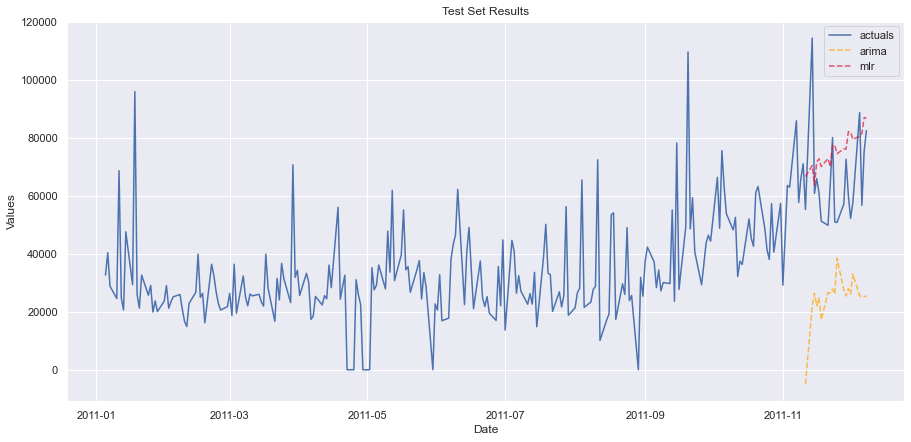

In [41]:
f.plot_test_set()

We see that the MLR model performed much better on the test set, whereas the ARIMA model didn't seem to come close. Let's now plot both models' forecasted values.

arima LevelTestSetRMSE: 44408.22553323487
mlr LevelTestSetRMSE: 19345.348084683657


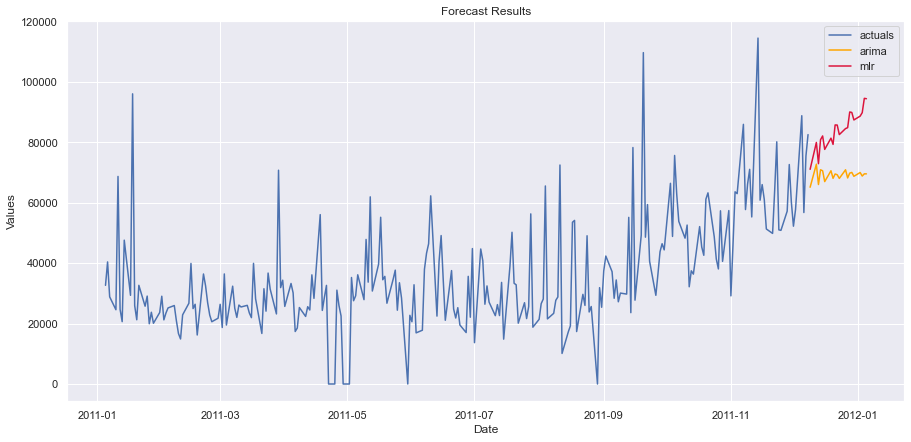

In [42]:
f.plot(print_attr=['LevelTestSetRMSE'])

As suspected, the MLR by far outclassed the ARIMA model on the test set.

With scikit-learn models, such as MLR, permutation feature importance information from the [eli5](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html) package can be saved and exported to a dataframe, analogous to saving summary stats from an ARIMA model. Each weight is the average decrease in accuracy when that particular variable is substituted for random values over 10 iterations, so the variables that cause the largest decreases are considered the most important. The output of the exported data is therefore ranked in terms of which variables are most-to-least important, according to this methodology.

In [43]:
f.save_feature_importance()

In [44]:
f.export_feature_importance(model='mlr')

,weight,std
feature,,
AR1,1.273525,0.072415
AR2,0.655428,0.097872
AR3,0.280061,0.042075
AR4,0.139121,0.025561
dayofweekcos,0.011148,0.008737
t,0.004863,0.005369
AR10,0.002158,0.002784
dayofweeksin,0.001942,0.002053
AR5,0.001658,0.002597


### Elasticnet and Auto-Forecasting

To optimize the hyperparameters of and auto-forecast with models in scalecast, we use a grid-search approach on a validation set of data--a period of time before the test set. The grids are completely customizable, but standard template grids are available by calling the function below:

In [45]:
GridGenerator.get_example_grids()

`GridGenerator.get_empty_grids()` is also available. We could call this then open the created file (Grids.py) and fill in the empty dictionary with hyperparameter values that we want to use. The example grids can usually be used for adequate performance, but contributions to improving the default values are welcome. You are also more-than-welcome to open the Grids.py file locally and making adjustments as you see fit.

These grids are saved to your working directory as Grids.py. Their structure is that of `Dict[str:list-like]` and scalecast automatically knows how to look for them. You can also pass your own grid manually by using `ingest_grid()` and passing a `str` value, which corresponds to a namespace of a grid in the Grids.py file, or a grid of `dict` type. By default, the code below will ingest the grid named elasticnet from the Grids.py file in this same directory.

You can also create really big grids and limit them randomly by calling `limit_grid_size(n:int|float)`. If `int`, must be >0 to denote the number of combinations in the grid to keep. If `float`, must be between 0 and 1 to represent a portion of the grid's original size to randomly keep. `random_seed` is available as an argument in this method and is `None` by default.

In [46]:
f.set_validation_length(10)
f.set_estimator('elasticnet')
# unlike testing, tuning is non-dynamic by default, but this can be changed by passing dynamic_tuning=True as an argument below
f.tune() # automatically imports the elasticnet grid from Grids.py
# unlike tuning, testing is dynamic by default, but this can be changed by passing dynamic_testing=False as an argument below
f.auto_forecast()
f.save_feature_importance()

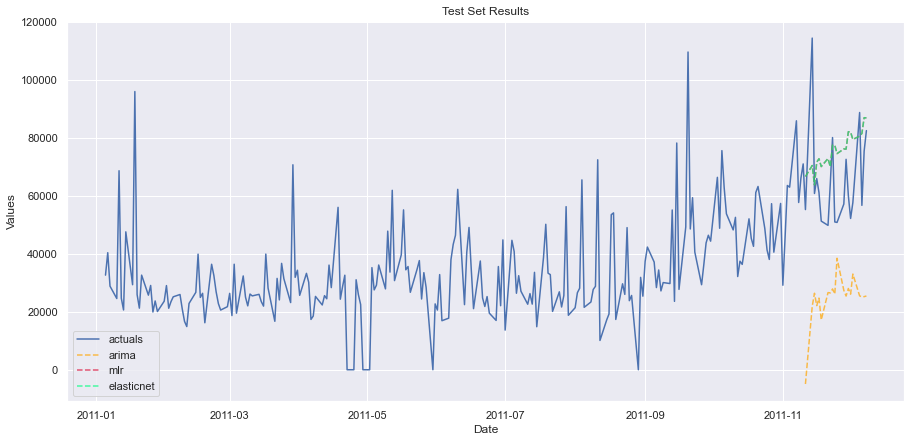

In [47]:
f.plot_test_set()

arima LevelTestSetRMSE: 44408.22553323487
mlr LevelTestSetRMSE: 19345.348084683657
elasticnet LevelTestSetRMSE: 19345.36575356768


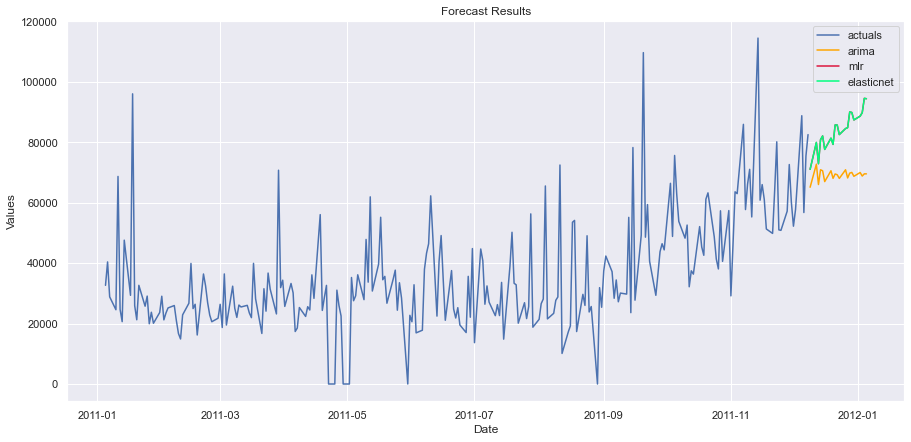

In [48]:
f.plot(print_attr=['LevelTestSetRMSE'])

In this instance, the regularization performed by the Elasticnet model resulted in nearly identical peformance to the MLR. We can see what hyperparameter values were selected from the tuning process by exporting the evaluated validation grid to a dataframe.

In [49]:
f.export_validation_grid(model='elasticnet').sort_values(['metric_value']).head(15)

,alpha,l1_ratio,normalizer,validation_length,validation_metric,metric_value
14,0.1,1.0,None,10,rmse,17296.785029
29,0.2,1.0,None,10,rmse,17296.934367
44,0.3,1.0,None,10,rmse,17297.083707
59,0.4,1.0,None,10,rmse,17297.233050
74,0.5,1.0,None,10,rmse,17297.382394
89,0.6,1.0,None,10,rmse,17297.531740
104,0.7,1.0,None,10,rmse,17297.681089
119,0.8,1.0,None,10,rmse,17297.830440
134,0.9,1.0,None,10,rmse,17297.979793
149,1.0,1.0,None,10,rmse,17298.129148


Since this model has a 1 value for its l1_ratio, it is functionally identical to a lasso model. The selected alpha value was 0.1, meaning its coefficient values were tapered. Like the MLR, we can export Elasticnet feature importance:

In [50]:
f.export_feature_importance(model='elasticnet')

,weight,std
feature,,
AR1,1.280138,0.093635
AR2,0.636605,0.045742
AR3,0.292922,0.030626
AR4,0.150466,0.012797
dayofweekcos,0.012442,0.007643
t,0.008292,0.003385
dayofweeksin,0.001435,0.002279
AR10,0.000493,0.001022
AR5,0.000152,0.002351


As expected, the values here are very similar to what we saw in the MLR feature importance.

### Auto-Forecasting with a Loop

In the same way we automatically tuned and forecasted with an elasticnet model, we can choose many models to forecast with using `tune_test_forecast()`.

In [51]:
models = ('knn','mlp','svr')

This example only uses a few models, but all the available models can be seen by running the code below. Note all models, except combo, can be tuned this way.

In [52]:
# not useful for anything other than seeing all model possibilities
print(*_estimators_,sep='\n')

mlr
mlp
gbt
xgboost
lightgbm
rf
elasticnet
svr
knn
arima
hwes
prophet
silverkite
combo


Let's call the loop and save all feature info so that we can export that information later.

In [53]:
f.tune_test_forecast(models,feature_importance=True,summary_stats=True) # dynamic_tuning = False and dynamic_testing = True are defaults in this function

See the results on the test set.

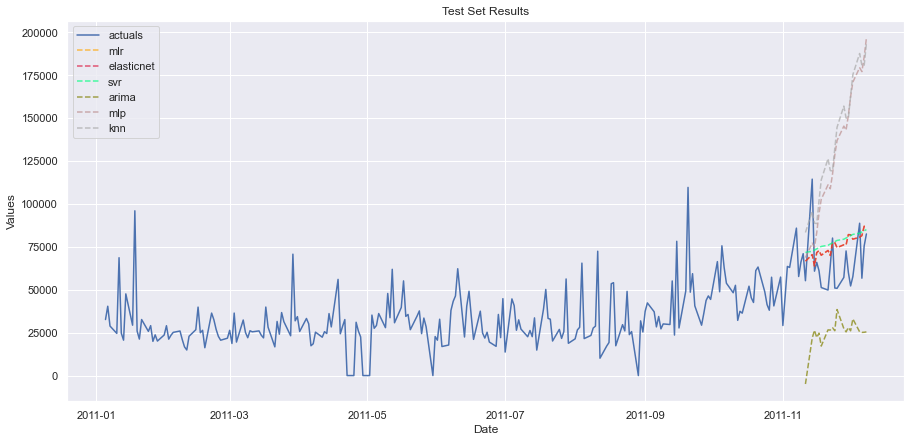

In [54]:
f.plot_test_set(order_by='LevelTestSetRMSE')

Two of these models happened to predict the test set very poorly, but using a variety of models and tuning them carefully, one or two (or more) usually emerge as appearing reasonable to implement. Let's now see the forecasts and level test-set RMSE from all these models.

mlr LevelTestSetRMSE: 19345.348084683657
elasticnet LevelTestSetRMSE: 19345.36575356768
svr LevelTestSetRMSE: 20788.40922853734
arima LevelTestSetRMSE: 44408.22553323487
mlp LevelTestSetRMSE: 77553.29098008816
knn LevelTestSetRMSE: 81391.03705932213


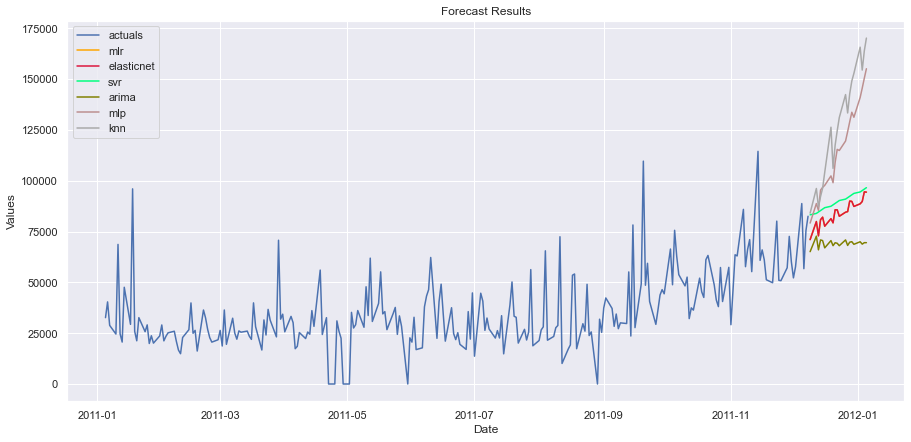

In [55]:
f.plot(order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'])

Let's focus on only the models that came out farther ahead than the others. We can pass the `models='top_3'` argument to this function and rerun. Note, now that the ARIMA model will not be displayed (which was run on level data), we will have to set `level=True` to view the forecasts at level.

mlr LevelTestSetRMSE: 19345.348084683657
elasticnet LevelTestSetRMSE: 19345.36575356768
svr LevelTestSetRMSE: 20788.40922853734


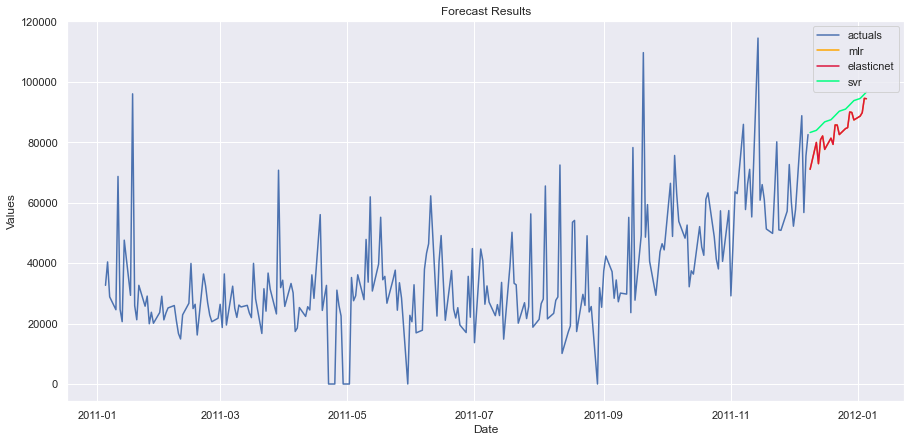

In [56]:
f.plot(models='top_3',order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

### Prophet and Silverkite

In addition to the scikit-learn and statsmodels forecasting models we have already explored, two other forecasting models from popular libraries are available for use: Facebook [Prophet](https://facebook.github.io/prophet/) and LinkedIn Silverkite (from the [greykite](https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library) package). Calling them and using them are as easy as any other forecasting model in this package. The `Xvars` argument is available in both models--you can also tune them using the grid-search method. But, since they select a lot of their own regressors and optimize themselves by default, it is sometimes time-saving to manually forecast them with default parameters.

In [57]:
f.set_estimator('prophet')
f.manual_forecast()

In [58]:
f.set_estimator('silverkite')
f.manual_forecast()
f.save_summary_stats()

Note, summary stats are available for silverkite but not Prophet -- contributions are welcome to get summary stats for Prophet.

After forecasting with Silverkite, we need to reset some matplotlib parameters for plotting to work.

In [59]:
matplotlib.use('nbAgg')
%matplotlib inline
sns.set(rc={'figure.figsize':plot_dim})

Let's see how these 2 new models performed compared with the top-3 models identified before.

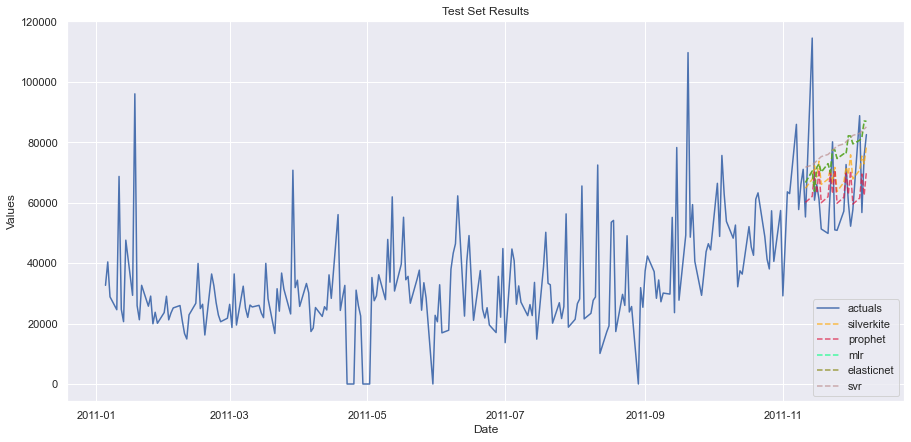

In [60]:
f.plot_test_set(models=['svr','mlr','elasticnet','prophet','silverkite'],order_by='LevelTestSetRMSE',level=True)

silverkite LevelTestSetRMSE: 16517.14274718804
prophet LevelTestSetRMSE: 16701.255007946897
mlr LevelTestSetRMSE: 19345.348084683657
elasticnet LevelTestSetRMSE: 19345.36575356768
svr LevelTestSetRMSE: 20788.40922853734


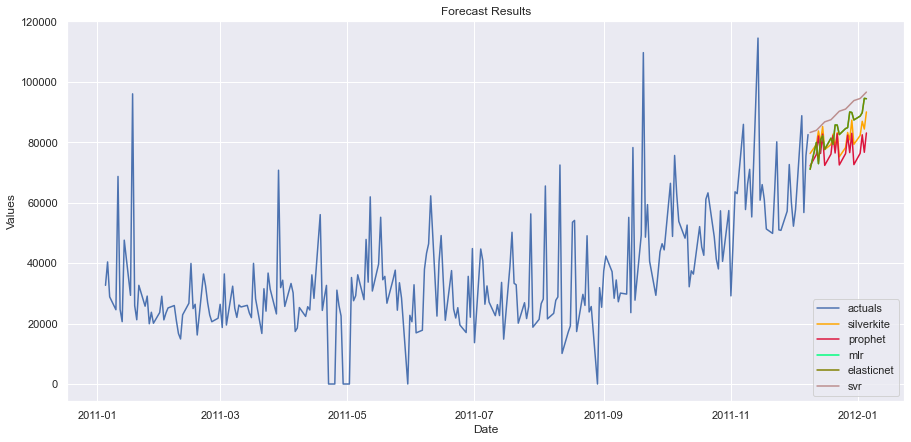

In [61]:
f.plot(models=['svr','elasticnet','mlr','prophet','silverkite'],order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

It looks like silverkite and prophet are now our first and second-best performing models respectively, using the test-set RMSE as the metric to decide this.

### Combination Modeling

The last model concept we will explore is combination modeling. There are three types of combinations:
- simple: a simple average of a group of models.
- weighted: a weighted average of a group of models. Weights can be passed manually (as we do below) or set automatically based on a metric passed to the `determine_best_by` parameter.
- splice: a splice of two or more models at one or more future splice points. All metrics, fitted values, and test-set metrics from this model will be identical to the simple average.

We will be using simple and weighted average combination modeling only.

In [62]:
f.set_estimator('combo')
f.manual_forecast(how='simple',models=['silverkite','prophet','mlr','elasticnet','svr'],determine_best_by=None,call_me='avg')
f.manual_forecast(how='weighted',models=['silverkite','prophet','mlr','elasticnet','svr'],weights=(5,4,3,2,1),determine_best_by=None,call_me='weighted')

It could be argued that the combination modeling performed above is a form of data leakage--we selected the five best models based on performance on the test set. It is possible that the resulting combination models will thusly be overfit to the test set. By default, deterimine_best_by in both of these combination types is `'ValidationMetricValue'`. This is a way to ensure data leakage does not occur. Since we didn't tune all the models we want to combine, we can't really use this technique effectively in this example.

The weighted average model can accept weights as arguments that add to 0 or not--if not, they will be rebalanced to do so. If determine_best_by is specified, weights can be left to None and the weights will be chosen automatically. Again, be careful to not overfit models this way.

All information available for other models, including fitted values and test-set metrics, are also available for these combo models.

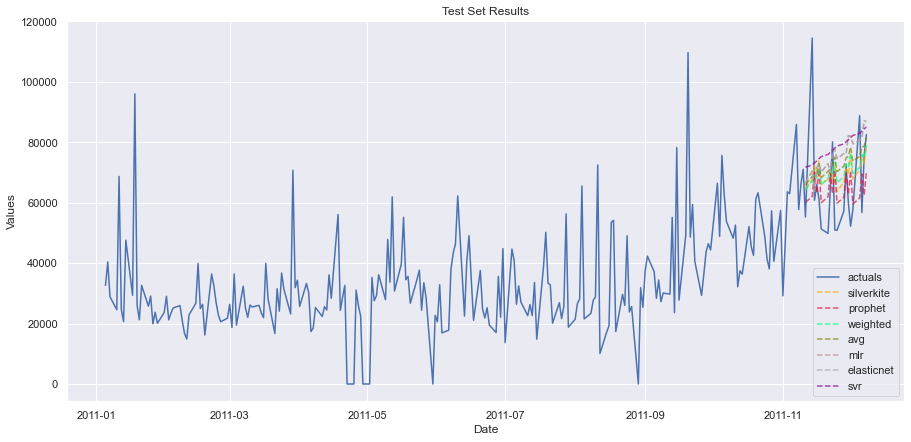

In [63]:
f.plot_test_set(models=['silverkite','prophet','mlr','elasticnet','svr','avg','weighted'],order_by='LevelTestSetRMSE',level=True)

silverkite LevelTestSetRMSE: 16517.14274718804
prophet LevelTestSetRMSE: 16701.255007946897
weighted LevelTestSetRMSE: 16808.69231414476
avg LevelTestSetRMSE: 17703.377708722364
mlr LevelTestSetRMSE: 19345.348084683657
elasticnet LevelTestSetRMSE: 19345.36575356768
svr LevelTestSetRMSE: 20788.40922853734


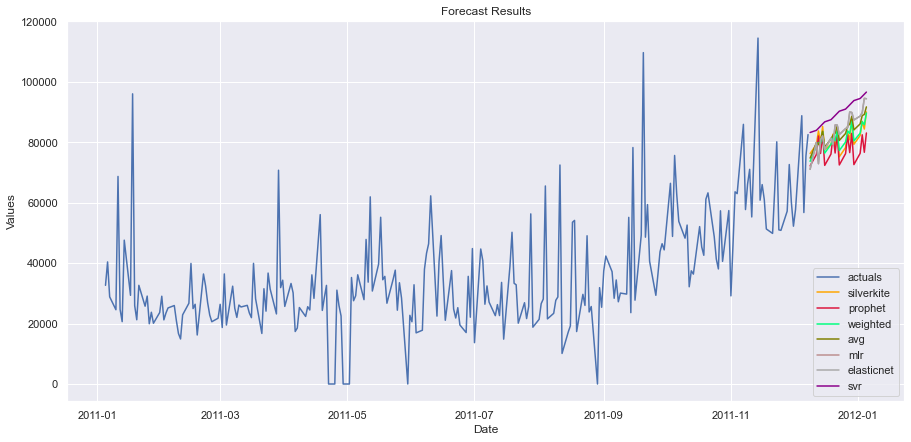

In [64]:
f.plot(models=['silverkite','prophet','mlr','elasticnet','svr','avg','weighted'],order_by='LevelTestSetRMSE',print_attr=['LevelTestSetRMSE'],level=True)

### Export Results to Excel

Now that we have 7 models that offer interesting ranges of predictions (and a few more that look a lot worse), let's export results to Excel to view later. The first function below exports a workbook with five tabs that offer information including forecasted values, level forecasted values, descriptive information about each model, and test-set prediction. The second two functions export feature info and validation grids, and they have to_excel in the method name because they automatically put each model's info on a separate tab. The last function exports all stored regressors to a dataframe which we can save as a csv. This last function also has a dropna argument that we can set to True if want to drop all NA observations before exporting.

In [65]:
f.export(to_excel=True,determine_best_by='LevelTestSetRMSE',excel_name='eCommerce_results.xlsx')
f.all_feature_info_to_excel(excel_name='eCommerce_feature_info.xlsx') 
f.all_validation_grids_to_excel(excel_name='eCommerce_validation_grids.xlsx')
f.export_Xvars_df().to_csv('eCommerce_Xvars.csv',index=False)